<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Transforming with Ops

In the previous notebook, we learned how to use NVTabular to Extract data from one data source and Load it into a different file format, but we are still missing the T from ETL: Transform. In this notebook, we will learn how to transform with [Ops](https://nvidia-merlin.github.io/NVTabular/main/api/ops/index.html).<br><br>
<b>Learning Objectives</b>:
* Learn how to use prebuilt Ops.
* Learn how create user defined Ops with the [LambdaOp](https://nvidia-merlin.github.io/NVTabular/main/api/ops/lambdaop.html).
* Learn why and how to [fit](https://nvidia-merlin.github.io/NVTabular/main/api/workflow.html#nvtabular.workflow.Workflow.fit) the dataset.

First, let's load our libraries and a view of our data.

In [1]:
import cudf
import glob
import nvtabular as nvt

df = cudf.read_parquet("data/parquet_out/*.parquet")
df.head()

,STATION,DATE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed
0,72058700184,2011-05-01T00:00:00,72.0,75.0,<NA>,89.0,<NA>,130.0,9.0
1,72058700184,2011-05-01T00:15:00,72.0,75.0,<NA>,89.0,<NA>,120.0,9.0
2,72058700184,2011-05-01T00:35:00,72.0,75.0,<NA>,89.0,<NA>,120.0,11.0
3,72058700184,2011-05-01T01:00:00,72.0,75.0,<NA>,89.0,<NA>,130.0,14.0
4,72058700184,2011-05-01T01:15:00,72.0,75.0,<NA>,89.0,<NA>,130.0,13.0


In [2]:
df.describe()

,STATION,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed
count,4.857160e+05,466931.000000,467217.000000,181930.000000,466923.000000,385802.000000,457207.000000,467754.000000
mean,7.220550e+10,51.801150,64.647738,0.012144,69.356162,56.517037,146.610354,6.693965
std,1.601237e+08,19.543238,16.780893,0.061679,25.092902,15.570599,118.231871,6.197363
min,7.205870e+10,-37.000000,-5.000000,0.000000,0.000000,-6.000000,0.000000,0.000000
25%,7.205870e+10,36.000000,53.000000,0.000000,52.000000,45.000000,20.000000,3.000000
50%,7.205870e+10,56.000000,68.000000,0.000000,74.000000,59.000000,140.000000,6.000000
75%,7.242309e+10,69.000000,77.000000,0.000000,90.000000,70.000000,240.000000,9.000000
max,7.242309e+10,88.000000,108.000000,2.000000,100.000000,84.000000,360.000000,2237.000000


### Prebuilt Ops

NVTabular has a few prebuilt [Ops](https://nvidia-merlin.github.io/NVTabular/main/api/ops/index.html). What is a high [dry bulb temperature](https://www.weather.gov/source/zhu/ZHU_Training_Page/definitions/dry_wet_bulb_definition/dry_wet_bulb.html)? What is a low wet bulb temperature? Let's [Normalize](https://nvidia-merlin.github.io/NVTabular/main/api/ops/normalize.html) these two columns to answer these questions. [Standardizing](https://stats.idre.ucla.edu/stata/faq/how-do-i-standardize-variables-in-stata/) our data gives us a scale invariant way to compare our numbers, so let's do so with the `Normalize` Op. 

Ops can be applied to a [ColumnGroup](https://nvidia-merlin.github.io/NVTabular/main/resources/architecture.html?highlight=columngroup) like so:

`features = [ column_name, ...] >> op1 >> op2 >> ...`

Note that when we apply an Op to a list of strings, it will automatically turn the list into a ColumnGroup.

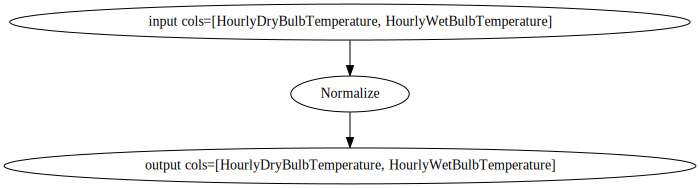

In [3]:
columns = ["HourlyDryBulbTemperature", "HourlyWetBulbTemperature"]
normalized_cols = columns >> nvt.ops.Normalize()
normalized_cols.graph

### The LambdaOp
While the prebuilt operations are useful, we can build our own with the [LambdaOp](https://nvidia-merlin.github.io/NVTabular/main/api/ops/lambdaop.html).

In the data [documentation](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf), it states that the temperatures are in Fahrenheit. Let's convert `HourlyDewPointTemperature` to Celsius, which is frequently used in scientific analysis.

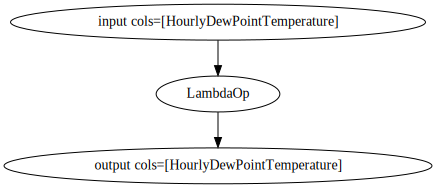

In [4]:
columns = ["HourlyDewPointTemperature"]

def fahrenheit_to_celsius(col):
    return (col - 32) * (5 / 9)

celsius_cols = columns >> nvt.ops.LambdaOp(fahrenheit_to_celsius)
celsius_cols.graph

### Difference Lag
If we want to see the difference between the rows, we can use the [DifferenceLag](https://nvidia-merlin.github.io/NVTabular/main/api/ops/differencelag.html) Op. In order to use it, our data must already be ordered. Thankfully, it is as shown by the `DATE` column. We can also specify partitions with the `partition_cols` parameter to prevent calculating a difference between different sets if data, like between our different `Station`s.

**TODO**: Update the code below to calculate the `1` lag difference for `HourlyWindSpeed`. Use the [documentation](https://nvidia-merlin.github.io/NVTabular/main/api/ops/differencelag.html) as a hint or click the `...` for an answer.

In [5]:
lagged_cols = (
    ["HourlyWindSpeed"]
    >> nvt.ops.DifferenceLag(partition_cols=FIXME, shift=FIXME)
)
lagged_cols.graph

NameError: name 'FIXME' is not defined

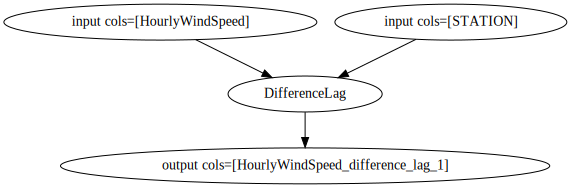

In [6]:
lagged_cols = (
    ["HourlyWindSpeed"]
    >> nvt.ops.DifferenceLag(partition_cols=["STATION"], shift=1)
)
lagged_cols.graph

### Data Quality Tools

Even though we have already removed columns with empty values, we can see that there are still individual cells with empty values. We could fill these missing values with a constant value or a median, but if we do, we would also like to leave a flag to indicate that these values were altered.

NVTabular has built in operations to do both steps at once. They will create a new column with a binary flagged tracking the changed columns.
* [FillMissing](https://nvidia-merlin.github.io/NVTabular/main/api/ops/fillmissing.html): Replaces missing values with a constant pre-defined value.
* [FillMedian](https://nvidia-merlin.github.io/NVTabular/main/api/ops/fillmedian.html): Replaces missing values with the median value for the column.

**TODO**: Choose either `FillMissing` or `FillMedian` and apply it to all of the numbered columns. Set `add_binary_cols` to `True`.

In [ ]:
remaining_cols = ["HourlyWindDirection", "HourlyRelativeHumidity"]
numbered_cols = remaining_cols + lagged_cols + celsius_cols + normalized_cols
numbered_cols = numbered_cols >> nvt.ops.FIXME(FIXME)
numbered_cols.graph

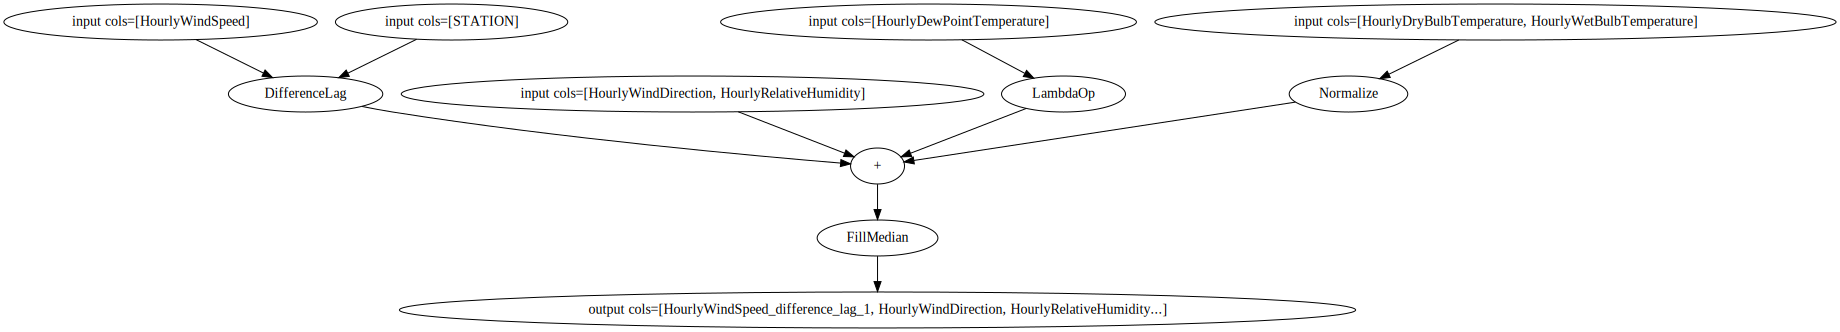

In [7]:
remaining_cols = ["HourlyWindDirection", "HourlyRelativeHumidity"]
numbered_cols = remaining_cols + lagged_cols + celsius_cols + normalized_cols
numbered_cols = numbered_cols >> nvt.ops.FillMedian(add_binary_cols=True)
numbered_cols.graph

## Building the full ETL Pipeline

Time to save our data like before and verify the results. We'll add back in the `STATION` and `DATE` so we can have all of our fields in the `all_cols` columnGroup.

**TODO**: Please fill in the FIXMEs below to setup the [workflow](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html#module-nvtabular.workflow.workflow) and [dataset](https://nvidia-merlin.github.io/NVTabular/main/api/dataset.html#module-nvtabular.io.dataset). Feel free to use the previous notebook as a hint. Click the `...` below for an answer.

In [ ]:
all_cols =  numbered_cols + ["STATION", "DATE"]
file_paths = glob.glob("data/parquet_out/*.parquet")
workflow = nvt.Workflow(FIXME)
dataset = nvt.Dataset(FIXME, engine="parquet")
workflow.column_group.graph

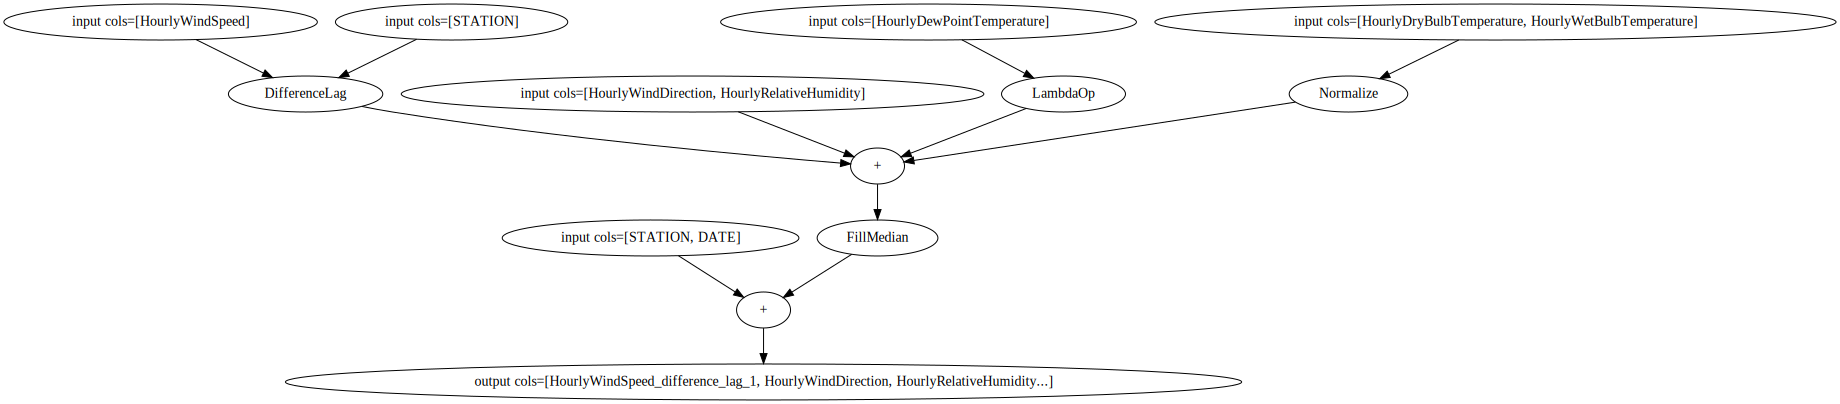

In [8]:
all_cols =  numbered_cols + ["STATION", "DATE"]
file_paths = glob.glob("data/parquet_out/*.parquet")
workflow = nvt.Workflow(all_cols)
dataset = nvt.Dataset(file_paths, engine="parquet")
workflow.column_group.graph

### Fitting the data

One more thing that we will need to do differently from last time is [fit](https://nvidia-merlin.github.io/NVTabular/main/resources/api/workflow.html#nvtabular.workflow.Workflow.fit) the data. `fit` will collect statistical information on our dataset, similar to the [scikit-learn](https://scikit-learn.org/stable/data_transforms.html) API.

For instance, if we want to [Normalize](https://nvidia-merlin.github.io/NVTabular/main/api/ops/normalize.html#nvtabular.ops.Normalize) our temperature columns by subtracting the average and dividing by the standard deviation, `workflow.fit()` will calculate the average and standard deviation based on our three files. Then, we can normalize the temperature for any future files without having to recalculate the average and standard deviation again.

In [9]:
workflow.fit(dataset)

### Running the Pipeline
With everything setup, we can run our full ETL pipeline like we did in the last lab. If this pipeline has ran before, let's remove the previous output to make way for new data.

In [10]:
!rm -rf data/transformed_out

**TODO**: Fill in the missing parameters below. This time, let's split our output data into `4` `.parquet` files using [to_parquet](https://nvidia-merlin.github.io/NVTabular/main/resources/api/dataset.html#nvtabular.io.dataset.Dataset.to_parquet). We can do so with the `out_files_per_proc` parameter.

If you don't have the terminal open from the previous lab monitoring the GPU, try running the following command in a terminal to see how it impacts our hardware:

`watch -n0.1 nvidia-smi --query-gpu=index,memory.used,memory.total,utilization.gpu --format=csv`

In [ ]:
workflow.transform(FIXME).to_parquet(
    output_path="data/transformed_out/", out_files_per_proc=FIXME
)

In [11]:
workflow.transform(dataset).to_parquet(
    output_path="data/transformed_out/", out_files_per_proc=4
)

Finally, let's look at the output to verify that our output columns match the ones created by our graph in `workflow.column_group.graph`.

In [12]:
df_transformed_out = cudf.read_parquet("data/transformed_out/*.parquet")
df_transformed_out.head()

,HourlyWindSpeed_difference_lag_1,HourlyWindDirection,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyWetBulbTemperature,HourlyWindSpeed_difference_lag_1_filled,HourlyWindDirection_filled,HourlyRelativeHumidity_filled,HourlyDewPointTemperature_filled,HourlyDryBulbTemperature_filled,HourlyWetBulbTemperature_filled,STATION,DATE
0,-1.0,150.0,62.0,22.777778,1.391598,0.159465,False,False,False,False,False,True,72058700184,2011-05-20T14:35:00
1,-1.0,140.0,66.0,23.888889,1.391598,0.159465,False,False,False,False,False,True,72058700184,2011-05-20T15:00:00
2,-5.0,0.0,94.0,26.111111,0.974457,0.159465,False,False,False,False,False,True,72058700184,2012-09-05T22:15:00
3,3.0,220.0,94.0,26.111111,0.974457,0.159465,False,False,False,False,False,True,72058700184,2012-09-05T22:35:00
4,3.0,150.0,66.0,22.777778,1.272415,0.159465,False,False,False,False,False,True,72058700184,2011-05-20T15:15:00


There should be a number of `_filled` boolean columns indicating whether or not a missing value was replaced in the corresponding column. For instance, `HourlyWetBulbTemperature_filled` decribes if `HourlyWetBulbTemperature` was altered.

Congratulations, you've completed the basics of NVTabular! So far, our GPU monitoring has shown that we've only been using 1 GPU. In the next lab, we will learn how to scale NVTabular to all of them.

Speaking of, please run the below cell to clear the GPU resources before moving on to the [next notebook](3_Op_Optimization.ipynb).

In [13]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>